In [3]:
from split_data import split
import numpy as np
import torch
from torchvision.datasets import ImageFolder
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

from utils import *


In [4]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using {device}")

Using mps


In [17]:
source_path = "../Data/Augmentation/Apple"
training_path = "../train_data/Apple"
testing_path = "../test_data/Apple"
train_test_ratio = 0.7
split(source_path, training_path, testing_path, train_test_ratio) 

Finish splitting Apple_scab
[Training Samples:700, Testing Samples:300]   Original Samples:1000
---------------------
Finish splitting No_leaves
[Training Samples:800, Testing Samples:343]   Original Samples:1143
---------------------
Finish splitting Healthy
[Training Samples:1151, Testing Samples:494]   Original Samples:1645
---------------------
Finish splitting Cedar_apple_rust
[Training Samples:700, Testing Samples:300]   Original Samples:1000
---------------------
Finish splitting Black_rot
[Training Samples:700, Testing Samples:300]   Original Samples:1000
---------------------
Total Training Samples: 4051, Testing Samples: 1737, Total Samples: 5788


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


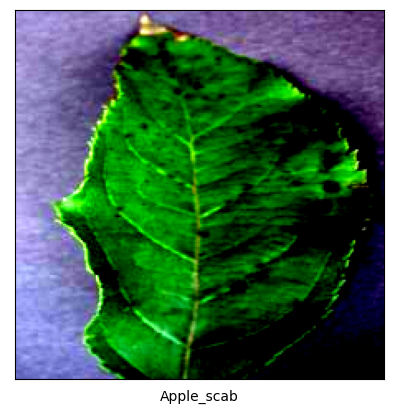

In [18]:
# -------------[transform into suitable size for transfer learning]--------------------
transformation = preprocess()

train_dataset = ImageFolder(training_path, transform = transformation)

test_dataset = ImageFolder(testing_path,transform = transformation)

classes = train_dataset.classes

#display the first image in the dataset
display_img(*train_dataset[0], classes)

In [7]:
batch_size = 4
train_val_ratio = 0.8
val_size = int(np.round(len(train_dataset) * (1-train_val_ratio)))
train_size = len(train_dataset) - val_size 

train_data, val_data = random_split(train_dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size, num_workers = 4, pin_memory = True)

test_dl = DataLoader(test_dataset, batch_size, num_workers = 4, pin_memory = True)

Length of Train Data : 3241
Length of Validation Data : 810


(w - F + 2P)/S + 1

### EfficientNet B0 Model

In [54]:
efficient_model = load_efficient_net().to(device)

num_classes = len(classes)

efficient_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=num_classes, bias=True)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(efficient_model.parameters(), lr=0.001)

# efficientNet B0 model
efficient_results = train(model=efficient_model,
                train_dataloader=train_dl,
                val_dataloader=val_dl,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=10,
                device=device)

torch.save(efficient_model, "../Models/apple_efficient_model.pt")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5207 | train_acc: 0.8345 | train_f1: 0.8352 | val_loss: 0.1958 | val_acc: 0.9594 | val_f1: 0.9593 | 
Epoch: 2 | train_loss: 0.3343 | train_acc: 0.8893 | train_f1: 0.8902 | val_loss: 0.1280 | val_acc: 0.9741 | val_f1: 0.9741 | 
Epoch: 3 | train_loss: 0.3118 | train_acc: 0.8915 | train_f1: 0.8923 | val_loss: 0.1070 | val_acc: 0.9754 | val_f1: 0.9753 | 
Epoch: 4 | train_loss: 0.2852 | train_acc: 0.9081 | train_f1: 0.9081 | val_loss: 0.1296 | val_acc: 0.9643 | val_f1: 0.9642 | 
Epoch: 5 | train_loss: 0.2664 | train_acc: 0.9137 | train_f1: 0.9145 | val_loss: 0.1351 | val_acc: 0.9643 | val_f1: 0.9642 | 
Epoch: 6 | train_loss: 0.2577 | train_acc: 0.9075 | train_f1: 0.9084 | val_loss: 0.1092 | val_acc: 0.9778 | val_f1: 0.9778 | 
Epoch: 7 | train_loss: 0.2450 | train_acc: 0.9115 | train_f1: 0.9124 | val_loss: 0.1205 | val_acc: 0.9766 | val_f1: 0.9765 | 
Epoch: 8 | train_loss: 0.2151 | train_acc: 0.9229 | train_f1: 0.9229 | val_loss: 0.3327 | val_acc: 0.9667 | val_f1: 0.

In [18]:
# accuracy for efficientNet b0
efficient_model = torch.load("../Models/apple_efficient_model.pt")
test_run(efficient_model, test_dl, device, batch_size, classes)

### MobileNetV2 Model

In [57]:
mobile_model = load_mobile_net().to(device)

mobile_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=False),
    nn.Linear(in_features=1280, out_features=num_classes, bias=True)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mobile_model.parameters(), lr=0.001)

# MobileNet V2 model
mobile_results = train(model=mobile_model,
                train_dataloader=train_dl,
                val_dataloader=val_dl,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=10,
                device=device)

torch.save(mobile_model, "../Models/apple_mobile_model.pt")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6134 | train_acc: 0.8052 | train_f1: 0.8059 | val_loss: 0.1780 | val_acc: 0.9741 | val_f1: 0.9741 | 
Epoch: 2 | train_loss: 0.3599 | train_acc: 0.8767 | train_f1: 0.8775 | val_loss: 0.1211 | val_acc: 0.9704 | val_f1: 0.9704 | 
Epoch: 3 | train_loss: 0.3153 | train_acc: 0.8875 | train_f1: 0.8883 | val_loss: 0.0798 | val_acc: 0.9877 | val_f1: 0.9877 | 
Epoch: 4 | train_loss: 0.2881 | train_acc: 0.9091 | train_f1: 0.9099 | val_loss: 0.1186 | val_acc: 0.9680 | val_f1: 0.9679 | 
Epoch: 5 | train_loss: 0.2773 | train_acc: 0.9023 | train_f1: 0.9031 | val_loss: 0.0622 | val_acc: 0.9889 | val_f1: 0.9889 | 
Epoch: 6 | train_loss: 0.2723 | train_acc: 0.9001 | train_f1: 0.9010 | val_loss: 0.0636 | val_acc: 0.9877 | val_f1: 0.9877 | 
Epoch: 7 | train_loss: 0.2582 | train_acc: 0.9103 | train_f1: 0.9111 | val_loss: 0.0809 | val_acc: 0.9729 | val_f1: 0.9728 | 
Epoch: 8 | train_loss: 0.2521 | train_acc: 0.9165 | train_f1: 0.9173 | val_loss: 0.0596 | val_acc: 0.9901 | val_f1: 0.

In [9]:
# MobileNet V2 accuracy
mobile_model = torch.load("../Models/apple_mobile_model.pt")
test_run(mobile_model, test_dl, device, batch_size, classes)

### Predicting Single Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


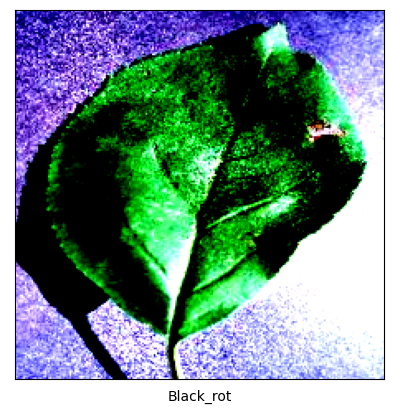

In [10]:
from PIL import Image
test_img_path = "/Users/afflatus/Documents/UoM_MSc/Diss/train_data/Black_rot/image (12).JPG"

img = Image.open(test_img_path)


img1 = transformation(img)

display_img(img1, predict(mobile_model, test_img_path, device), classes)